# Clayton Young EDA

In [2220]:
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns

- String to feed into funcition below as the link to MTA site. Series of dates from 2021-data are grouped by Sundays. 

In [2219]:
#http://web.mta.info/developers/turnstile.html
link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

dates=pd.Series(['2021-07-31', '2021-07-24', 
       '2021-07-17', '2021-07-10',
       '2021-07-03', '2021-06-26', 
       '2021-06-19', '2021-06-12', 
       '2021-06-05', '2021-05-29', 
       '2021-05-22', '2021-05-15', 
       '2021-05-08', '2021-05-01', 
       '2021-04-24', '2021-04-17', 
       '2021-04-10', '2021-04-03', 
       '2021-03-27', '2021-03-20', 
       '2021-03-13', '2021-03-06', 
       '2021-02-27', '2021-02-20', 
       '2021-02-13', '2021-02-06', 
       '2021-01-30', '2021-01-23', 
       '2021-01-16', '2021-01-09', 
       '2021-01-02'])
#Converting into datetime format to feed into function/website.
dates = pd.to_datetime(dates).dt.strftime('%y%m%d')


- Function to take a list of dates and gather the MTA data for dates specified.

In [3]:
#saving output of fxn to df
def rac(a_list, url):
    data = pd.DataFrame()
    for date in a_list:
        data = pd.concat([pd.read_csv(url.format(date)), data])
    return data

turnstiles_df = rac(dates, link)

In [50]:
TURNSTILES_DF = turnstiles_df.copy()

In [2218]:
turnstiles_df.shape

(6488049, 12)

- Removing trailing speace in column names pulled from MTA.

In [2222]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]


- Take the date and time fields into a single datetime column


In [2223]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [2224]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00


- Select list of stations in the Bronx. Verified manually. 

In [2351]:
bx_stations = ['3 AV 138 ST','3 AV-149 ST','138/GRAND CONC','149/GRAND CONC','161/YANKEE STAD','167 ST'
                 '170 ST','174 ST','174-175 STS','176 ST','182-183 STS','183 ST','219 ST','225 ST','231 ST',
                 '233 ST','238 ST','ALLERTON AV','BAYCHESTER AV','BEDFORD PK BLVD','BRONX PARK EAST',
                 'BROOK AV','BUHRE AV','BURKE AV','BURNSIDE AV','CASTLE HILL AV','CYPRESS AV',"E 143/ST MARY'S"
                 'E 149 ST', 'E 180 ST','EASTCHSTER/DYRE','ELDER AV','FORDHAM RD','FREEMAN ST','GUN HILL RD',
                 'HUNTS POINT AV','INTERVALE AV','JACKSON AV','KINGSBRIDGE RD','LONGWOOD AV','MIDDLETOWN RD',
                 'MORRIS PARK','MORISN AV/SNDVW','MOSHOLU PKWY','MT EDEN AV','NEREID AV','NORWOOD 205 ST',
                 'PARKCHESTER','PELHAM BAY PARK', 'PELHAM PKWY','PROSPECT AV','SIMPSON ST','ST LAWRENCE AV',
                 'TREMONT AV','V.CORTLANDT PK','WAKEFIELD/241','WEST FARMS SQ','WESTCHESTER SQ','WHITLOCK AV',
                 'WOODLAWN','ZEREGA AV']

- We see that the Bedford Park Boulevard–Lehman College isn't showing in the list of stations, so we'll check to see if 4 is listed under the BEDFORD PK BLVD station in addition to the B and D.


In [2354]:
#saving new dataframe with Bx stations only. 
bx_df=turnstiles_df[turnstiles_df['STATION'].isin(bx_stations)]

In [2385]:
#bx_df[bx_df['STATION']=='BEDFORD PK BLVD']['LINENAME'].unique()
pd.set_option('display.max_rows', 100)

#check to see if there are any duplicates and if so, why
bx_df[['LINENAME','STATION']].drop_duplicates().sort_values('STATION')

# The 161 Yankee stadium had the same 'linename' in different order. replaced the values to reflect they're the same. 
bx_df[bx_df['STATION']=='161/YANKEE STAD']['LINENAME'].value_counts()
bx_df.loc[bx_df['STATION'] == '161/YANKEE STAD', "LINENAME"] = "4BD"
#checking to see if change consolidated 
bx_df[bx_df['STATION']=='161/YANKEE STAD']['LINENAME'].value_counts()

#gettting rid of the station that's in brooklyn w/the same name as one in the Bx
bx_df=bx_df[~((bx_df['STATION']=='PROSPECT AV') & (bx_df['LINENAME']=='R'))]


All stations are accounted for in the Bronx.

- Check for duplicates. 

In [2130]:
(bx_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
255677,R314,R406,00-00-02,PROSPECT AV,2021-05-28 05:00:00,2
34922,N213,R154,00-00-00,TREMONT AV,2021-06-23 05:00:00,2
450441,R417,R222,00-03-01,PARKCHESTER,2021-03-26 05:00:00,2
443937,R417,R222,00-00-01,PARKCHESTER,2021-03-26 05:00:00,2
41426,N213,R154,00-00-05,TREMONT AV,2021-06-23 05:00:00,2
356286,R334,R367,00-05-00,233 ST,2021-07-23 01:00:00,1
356285,R334,R367,00-05-00,233 ST,2021-07-22 21:00:00,1
356312,R334,R367,00-05-00,233 ST,2021-07-27 09:00:00,1
356311,R334,R367,00-05-00,233 ST,2021-07-27 05:00:00,1
356310,R334,R367,00-05-00,233 ST,2021-07-27 01:00:00,1


Decent amount of duplicates... why?

In [2226]:
mask = ((bx_df["C/A"] == "N213") & 
(bx_df["UNIT"] == "R154") & 
(bx_df["SCP"] == "00-00-05") & 
(bx_df["STATION"] == "TREMONT AV") &
(bx_df['DATE_TIME'] == '2021-06-23 05:00:00'))

bx_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
77273,N213,R154,00-00-05,TREMONT AV,BD,IND,06/23/2021,05:00:00,REGULAR,369307076,100833056,2021-06-23 05:00:00
77274,N213,R154,00-00-05,TREMONT AV,BD,IND,06/23/2021,05:00:00,RECOVR AUD,369307075,100833056,2021-06-23 05:00:00


Recovery files are likely the issue. What percentage of the data are the recovery files?

In [2228]:
bx_df.DESC.value_counts()['RECOVR AUD']/bx_df.DESC.value_counts().sum()


0.005980709406693758

* 99% of data is regular. Remove the recovery entries and proceed. 

In [2229]:
bx_df = bx_df[(bx_df['DESC']=='REGULAR')]

# verify that filter worked and we removed the RECOVR AUD entries
(bx_df
 .groupby(["C/A", "UNIT", "LINENAME", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)

,C/A,UNIT,LINENAME,SCP,STATION,DATE_TIME,EXITS
0,C014,R246,R,00-00-00,PROSPECT AV,2020-12-26 03:00:00,1
360229,R334,R367,25,00-00-01,233 ST,2021-05-07 09:00:00,1
360227,R334,R367,25,00-00-01,233 ST,2021-05-07 01:00:00,1
360226,R334,R367,25,00-00-01,233 ST,2021-05-06 21:00:00,1
360225,R334,R367,25,00-00-01,233 ST,2021-05-06 17:00:00,1
360224,R334,R367,25,00-00-01,233 ST,2021-05-06 13:00:00,1
360223,R334,R367,25,00-00-01,233 ST,2021-05-06 09:00:00,1
360222,R334,R367,25,00-00-01,233 ST,2021-05-06 05:00:00,1
360221,R334,R367,25,00-00-01,233 ST,2021-05-06 01:00:00,1
360220,R334,R367,25,00-00-01,233 ST,2021-05-05 21:00:00,1


In [2231]:
# Get rid of other duplicate entries
bx_df.sort_values(["C/A", "UNIT", "LINENAME", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
bx_df.drop_duplicates(subset=["C/A", "UNIT", "LINENAME", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [2234]:
#check shape out now after filtering 
bx_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
207698,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,07/30/2021,21:00:00,REGULAR,1559803086,1728252251,2021-07-30 21:00:00
207697,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,07/30/2021,17:00:00,REGULAR,1559803113,1728252204,2021-07-30 17:00:00
207696,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,07/30/2021,13:00:00,REGULAR,1559803146,1728252166,2021-07-30 13:00:00
207695,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,07/30/2021,09:00:00,REGULAR,1559803168,1728252145,2021-07-30 09:00:00
207694,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,07/30/2021,05:00:00,REGULAR,1559803230,1728252121,2021-07-30 05:00:00


* No more duplicate Entries

### Dealing with odd counter behaviour (repeats/turnover)

In [2261]:
#creating df selecting each turnstile exiting data and selecting the first instance of each data entry
turnstiles_daily_hourly_bx = (bx_df
                        .groupby(['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DATE_TIME'])
                        ['EXITS'].first()).reset_index()

In [2262]:
#creating new columns in dataframe created by gathering each preceeding exit data 
turnstiles_daily_hourly_bx[["PREV_DATE_TIME", "PREV_EXITS"]] = (turnstiles_daily_hourly_bx
                                                       .groupby(['C/A','UNIT','SCP','STATION','LINENAME','DIVISION'])["DATE_TIME", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [2263]:
turnstiles_daily_hourly_bx.head(20)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,EXITS,PREV_DATE_TIME,PREV_EXITS
0,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,03:00:00,2021-01-01 03:00:00,3064432,NaT,NaN
1,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,07:00:00,2021-01-01 07:00:00,3064435,2021-01-01 03:00:00,3064432.0
2,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,11:00:00,2021-01-01 11:00:00,3064455,2021-01-01 07:00:00,3064435.0
3,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,15:00:00,2021-01-01 15:00:00,3064476,2021-01-01 11:00:00,3064455.0
4,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,19:00:00,2021-01-01 19:00:00,3064496,2021-01-01 15:00:00,3064476.0
5,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,23:00:00,2021-01-01 23:00:00,3064513,2021-01-01 19:00:00,3064496.0
6,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/02/2021,03:00:00,2021-01-02 03:00:00,3064515,2021-01-01 23:00:00,3064513.0
7,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/02/2021,07:00:00,2021-01-02 07:00:00,3064525,2021-01-02 03:00:00,3064515.0
8,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/02/2021,11:00:00,2021-01-02 11:00:00,3064551,2021-01-02 07:00:00,3064525.0
9,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/02/2021,15:00:00,2021-01-02 15:00:00,3064598,2021-01-02 11:00:00,3064551.0


- Drop rows where there isn't a previous date-we can't find how many entries there were for those days without the preceeding info. 

In [2264]:
turnstiles_daily_hourly_bx.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)

- Find how many negative hourly exits there were for each turnstile.  

In [2356]:
(turnstiles_daily_hourly_bx[turnstiles_daily_hourly_bx["EXITS"] < turnstiles_daily_hourly_bx["PREV_EXITS"]]
    .groupby(["C/A",'SCP', "UNIT", "LINENAME", "STATION"])
    .size().sort_values(ascending=False))

C/A   SCP       UNIT  LINENAME  STATION        
N205  02-00-00  R195  BD4       161/YANKEE STAD    1299
R333  00-00-01  R366  25        225 ST             1293
N203  00-00-01  R195  BD4       161/YANKEE STAD    1291
R401  00-00-00  R445  6         3 AV 138 ST        1279
R322  00-00-02  R386  25        174 ST             1245
                                                   ... 
R333  00-00-02  R366  25        225 ST                1
R334  00-00-00  R367  25        233 ST                1
      00-00-01  R367  25        233 ST                1
      00-00-02  R367  25        233 ST                1
C014  00-00-00  R246  R         PROSPECT AV           1
Length: 386, dtype: int64

- Adjusting the filter of max counters. This is an issue because the negative hourly exits suggest the counters were reset or going backward. 

In [2270]:
def get_daily_hourly_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    #Hourly exits are counted by subtracting the current turnstile's exits with the exits that came immediately before. 
    if counter < 0 :
        # Maybe counter is reversed?
        counter = -counter
        # if counter was reversed, this allows us to calculate the hourly exits by getting the positive value of the difference.
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

#since we're looking at turnstiles within stations at an hourly (4 hour) basis, we're setting max counter significantly lower than we would looking at station wide or daily counts. 
turnstiles_daily_hourly_bx["HOURLY_EXITS"] = turnstiles_daily_hourly_bx.apply(get_daily_hourly_counts, axis=1, max_counter=5000)

Check max values per four hour period.

- We can see that at a filter of 1M, the highest median count for a turnstile is less than 500. We're making the assumption that any turnstile data that is greater than 5K is likely.

In [2357]:
turnstiles_daily_hourly_bx

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,EXITS,PREV_DATE_TIME,PREV_EXITS,HOURLY_EXITS
1,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,07:00:00,2021-01-01 07:00:00,3064435,2021-01-01 03:00:00,3.064432e+06,3.0
2,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,11:00:00,2021-01-01 11:00:00,3064455,2021-01-01 07:00:00,3.064435e+06,20.0
3,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,15:00:00,2021-01-01 15:00:00,3064476,2021-01-01 11:00:00,3.064455e+06,21.0
4,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,19:00:00,2021-01-01 19:00:00,3064496,2021-01-01 15:00:00,3.064476e+06,20.0
5,C014,R246,00-00-00,PROSPECT AV,R,BMT,01/01/2021,23:00:00,2021-01-01 23:00:00,3064513,2021-01-01 19:00:00,3.064496e+06,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540325,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,12/31/2020,04:00:00,2020-12-31 04:00:00,1728236727,2020-12-31 00:00:00,1.728237e+09,2.0
540326,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,12/31/2020,08:00:00,2020-12-31 08:00:00,1728236736,2020-12-31 04:00:00,1.728237e+09,9.0
540327,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,12/31/2020,12:00:00,2020-12-31 12:00:00,1728236741,2020-12-31 08:00:00,1.728237e+09,5.0
540328,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,12/31/2020,16:00:00,2020-12-31 16:00:00,1728236751,2020-12-31 12:00:00,1.728237e+09,10.0


0.0

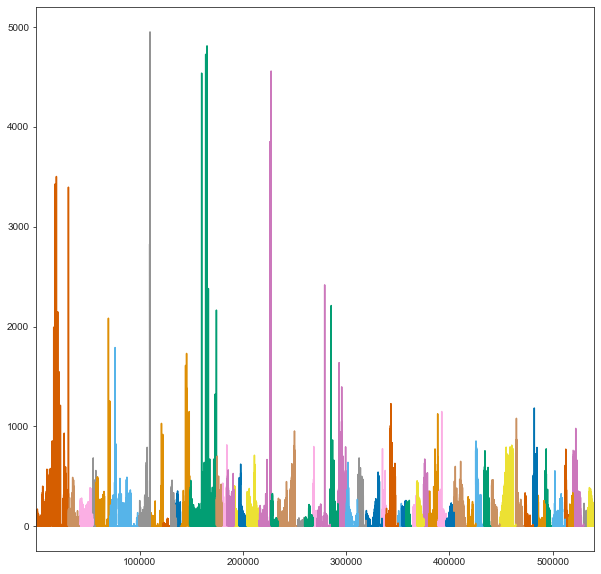

In [2276]:
turnstiles_daily_hourly_bx.sort_values('HOURLY_EXITS', ascending = False)
#This plot consolidates turnstiles by station and linename
turnstiles_daily_hourly_bx.groupby(['STATION','LINENAME'])['HOURLY_EXITS'].plot(figsize=(10,10))
plt.rcParams.update({'font.size': 10})

turnstiles_daily_hourly_bx.groupby(['STATION','LINENAME', 'SCP'])['HOURLY_EXITS'].std().sort_values(ascending=False)
#highest median for turnstile is 272/ mean is 570
#highest standard deviation is 10287-wow. These spikes look unnatural in this data. Changed filter to 5K. Will still use median as cetral tendency. 


#used the code below to find how many counts were above the filter above. 
turnstiles_daily_hourly_bx[turnstiles_daily_hourly_bx['HOURLY_EXITS']>=5000].count()['HOURLY_EXITS']/turnstiles_daily_hourly_bx.count()['HOURLY_EXITS']

In [2278]:
turnstiles_daily_hourly_bx.sort_values('HOURLY_EXITS', ascending = False)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,EXITS,PREV_DATE_TIME,PREV_EXITS,HOURLY_EXITS
110087,N225,R157,01-00-02,NORWOOD 205 ST,D,IND,12/26/2020,00:00:00,2020-12-26 00:00:00,4952,2021-07-30 21:00:00,52037.0,4952.0
165297,R262A,R195,04-00-04,161/YANKEE STAD,4BD,IRT,12/26/2020,03:22:00,2020-12-26 03:22:00,363227,2021-07-30 20:22:00,368039.0,4812.0
164000,R262A,R195,04-00-03,161/YANKEE STAD,4BD,IRT,12/26/2020,03:22:00,2020-12-26 03:22:00,94314,2021-07-30 20:22:00,99041.0,4727.0
227365,R293,R133,00-06-02,MOSHOLU PKWY,4,IRT,12/26/2020,00:00:00,2020-12-26 00:00:00,77276,2021-07-30 21:00:00,81836.0,4560.0
160109,R262A,R195,04-00-00,161/YANKEE STAD,4BD,IRT,12/26/2020,03:22:00,2020-12-26 03:22:00,151856,2021-07-30 20:22:00,156395.0,4539.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170974,R262B,R195,05-00-03,161/YANKEE STAD,4BD,IRT,03/17/2021,08:22:00,2021-03-17 08:22:00,63,2021-03-17 04:22:00,63.0,0.0
123739,R196,R306,00-00-00,238 ST,1,IRT,07/16/2021,05:00:00,2021-07-16 05:00:00,341164,2021-07-16 01:00:00,341164.0,0.0
226528,R293,R133,00-06-02,MOSHOLU PKWY,4,IRT,03/12/2021,08:00:00,2021-03-12 08:00:00,78526,2021-03-12 04:00:00,78526.0,0.0
170973,R262B,R195,05-00-03,161/YANKEE STAD,4BD,IRT,03/17/2021,04:22:00,2021-03-17 04:22:00,63,2021-03-17 00:22:00,63.0,0.0



### Consolidating the turnstiles to get total hourly exits per station.
- This is where we combine the turnstiles from each station to get the hourly totals for each station. Kept the linename because as we saw with some of the stations, multiple stations are grouped under the same name, and we're only able to tell the difference by the linename. 

In [2290]:
#station_hourly_bx contains the hourly sums of each staion/line combination 
station_hourly_bx = turnstiles_daily_hourly_bx.groupby(["STATION","LINENAME", "DATE_TIME"])['HOURLY_EXITS'].sum().reset_index()

#Create column for day of the week and time of day to find the averages per station and the max
station_hourly_bx['dayofweek']=station_hourly_bx.DATE_TIME.dt.dayofweek
station_hourly_bx['hourofday']=station_hourly_bx.DATE_TIME.dt.hour

#there are less than 20 counts for each one of these data. Removing. 
station_hourly_bx=station_hourly_bx[(station_hourly_bx['hourofday'] != 6)&
                  (station_hourly_bx['hourofday'] != 14)&
                  (station_hourly_bx['hourofday'] != 22)&
                  (station_hourly_bx['hourofday'] != 18)&
                  (station_hourly_bx['hourofday'] != 10)]


## Hourly exits sorted by station/line for 2021
- Looking at which stations have the most exiting foot traffic on average. Again, using the median as the measure of average to account for outliers. 

In [2291]:
annual_station_totals_hourly = station_hourly_bx.groupby(['STATION', 'LINENAME']).median()\
    .sort_values('HOURLY_EXITS', ascending=False)\
    .reset_index()

annual_station_totals_hourly.head(25)

,STATION,LINENAME,HOURLY_EXITS,dayofweek,hourofday
0,3 AV-149 ST,25,973.0,3.0,12.0
1,PARKCHESTER,6,939.0,3.0,12.0
2,149/GRAND CONC,245,702.0,3.0,12.0
3,HUNTS POINT AV,6,691.5,3.0,12.0
4,161/YANKEE STAD,BD4,673.5,3.0,12.0
5,GUN HILL RD,25,598.0,3.0,12.0
6,FORDHAM RD,BD,552.0,3.0,12.0
7,174 ST,25,549.5,3.0,10.0
8,TREMONT AV,BD,518.0,3.0,9.0
9,3 AV 138 ST,6,509.0,3.0,12.0


## NEXT STEPS:
- find weekly averages
- find daily averages
- find hourly (4 hour) averages


- Calculating median exits per week for each station then finding the calculating the mean for each station's weekly median. This give us an idea as to what the exiting foot traffic is like for each station on a weekly basis.

In [2296]:
weekly_plot_data=station_hourly_bx.groupby([pd.Grouper(freq='w', key='DATE_TIME'), 'STATION', 'LINENAME'])['HOURLY_EXITS'].median().sort_values(ascending=False)\
.reset_index().groupby('STATION').mean().sort_values('HOURLY_EXITS', ascending=False).reset_index()
weekly_plot_data



,STATION,HOURLY_EXITS
0,3 AV-149 ST,981.093750
1,PARKCHESTER,929.046875
2,149/GRAND CONC,706.015625
3,HUNTS POINT AV,704.062500
4,174 ST,551.406250
5,BURNSIDE AV,517.859375
6,3 AV 138 ST,506.546875
7,TREMONT AV,506.125000
8,161/YANKEE STAD,487.859375
9,BROOK AV,486.718750


Plot weekly averages for each station.

Text(0, 0.5, 'STATION')

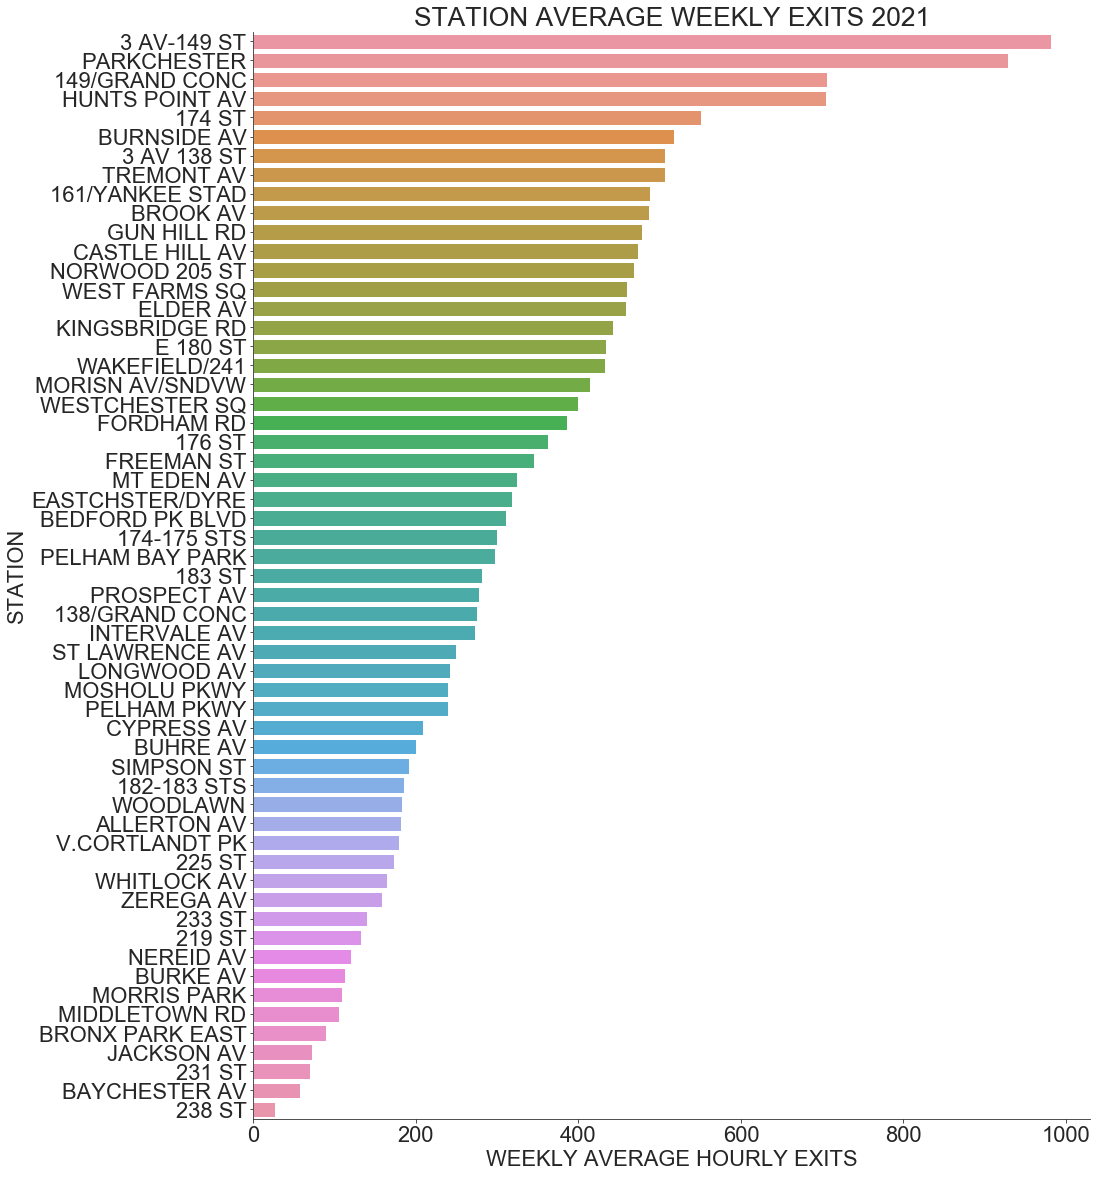

In [2360]:
weekly_plot_data=weekly_plot_data.rename(columns={'HOURLY_EXITS':'AVERAGE_HOURLY_EXITS'})
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,20))
sns.set_palette("colorblind")
sns.barplot(y=weekly_plot_data.STATION, x=weekly_plot_data['AVERAGE_HOURLY_EXITS'], data=weekly_plot_data)
sns.despine()
plt.title('STATION AVERAGE WEEKLY EXITS 2021')
plt.xlabel('WEEKLY AVERAGE HOURLY EXITS')
plt.ylabel('STATION')


#### Highest daily average hourly exits

In [2364]:
station_hourly_bx.groupby([pd.Grouper(freq='d', key='DATE_TIME'), 'STATION', 'LINENAME'])['HOURLY_EXITS'].median().sort_values(ascending=False)\
.reset_index().groupby('STATION').mean().sort_values('HOURLY_EXITS', ascending=False).reset_index()

,STATION,HOURLY_EXITS
0,3 AV-149 ST,1164.875576
1,PARKCHESTER,946.534562
2,149/GRAND CONC,767.073733
3,HUNTS POINT AV,753.099078
4,174 ST,607.218894
5,3 AV 138 ST,518.960829
6,BURNSIDE AV,513.225806
7,BROOK AV,513.048387
8,TREMONT AV,501.546083
9,ELDER AV,492.774194


#### Highest average hourly exits 

In [2366]:
station_hourly_bx.groupby([pd.Grouper(freq='h', key='DATE_TIME'), 'STATION', 'LINENAME'])['HOURLY_EXITS'].median().sort_values(ascending=False)\
.reset_index().groupby('STATION').mean().sort_values('HOURLY_EXITS', ascending=False).reset_index()

,STATION,HOURLY_EXITS
0,PARKCHESTER,1192.430448
1,3 AV-149 ST,1094.999229
2,HUNTS POINT AV,731.457430
3,149/GRAND CONC,719.117194
4,ELDER AV,596.612903
5,174 ST,582.806375
6,TREMONT AV,577.434950
7,161/YANKEE STAD,564.160200
8,NORWOOD 205 ST,555.056923
9,GUN HILL RD,534.407064


#### Highest average hourly exits by day of week and hour of day 

- Find busiest days for the busiest station by taking the median of the hourly exits by days of the week. Again, grouping days of the week after median calculated and taking the mean for each day of week. 

- This is the final dataframe we'll use to create a schedule of where our client will want to be at each day, for each our in the Bronx. 

In [2331]:
#station_hourly_bx contains the hourly sums of each staion/line combination. 
#We'll use this dataframe to calculate the median for each station/line to find the station with the maximum median exits for each hour of each day. 
stations_df=pd.DataFrame(station_hourly_bx.groupby(['dayofweek','hourofday', 'STATION','LINENAME'])\
                         .median().groupby(['dayofweek','hourofday']).idxmax().astype('str')\
                         .sort_values(['dayofweek','hourofday']).reset_index())


#splitting the idxmax and replacing the misc. characters
stations_df=pd.DataFrame(stations_df['HOURLY_EXITS'].str.split(',', n = 3, expand = True))
stations_df=stations_df.applymap(lambda x: x.replace("'", ''))
stations_df=stations_df.applymap(lambda x: x.replace("(", ''))
stations_df=stations_df.applymap(lambda x: x.replace(")", ''))
#renaming columns of the dataframe.
stations_df.rename(columns={0: "Day", 1: "Hour",2:'Station',3:'Line'}, inplace=True)


stations_df

,Day,Hour,Station,Line
0,0,0,3 AV-149 ST,25
1,0,1,PARKCHESTER,6
2,0,3,3 AV-149 ST,25
3,0,4,3 AV-149 ST,25
4,0,5,PARKCHESTER,6
...,...,...,...,...
121,6,17,PARKCHESTER,6
122,6,19,3 AV-149 ST,25
123,6,20,3 AV-149 ST,25
124,6,21,PARKCHESTER,6


- Since we gathered the index (station name/line) for the max median exits, we'll need to find the max values for those stations/lines and merge with that dataframe. 

In [2334]:
s_counts_df=pd.DataFrame(station_hourly_bx.groupby(['dayofweek','hourofday', 'STATION','LINENAME'])\
                         .median().groupby(['dayofweek','hourofday']).max().astype('str'))\
                        .sort_values(['dayofweek','hourofday']).reset_index()

#merge the actual max median hourly counts with the stations_df
stations_df['HOURLY_EXITS']=s_counts_df['HOURLY_EXITS']
stations_df

,Day,Hour,Station,Line,HOURLY_EXITS
0,0,0,3 AV-149 ST,25,783.0
1,0,1,PARKCHESTER,6,789.0
2,0,3,3 AV-149 ST,25,198.0
3,0,4,3 AV-149 ST,25,197.0
4,0,5,PARKCHESTER,6,115.5
...,...,...,...,...,...
121,6,17,PARKCHESTER,6,1076.5
122,6,19,3 AV-149 ST,25,1081.0
123,6,20,3 AV-149 ST,25,1118.5
124,6,21,PARKCHESTER,6,1258.0


- Plotting the value counts for stations with the highest median exits per hour per day. 

,index,Station
0,3 AV-149 ST,59
1,PARKCHESTER,45
2,149/GRAND CONC,8
3,138/GRAND CONC,5
4,HUNTS POINT AV,5
5,FORDHAM RD,2
6,GUN HILL RD,1
7,NORWOOD 205 ST,1


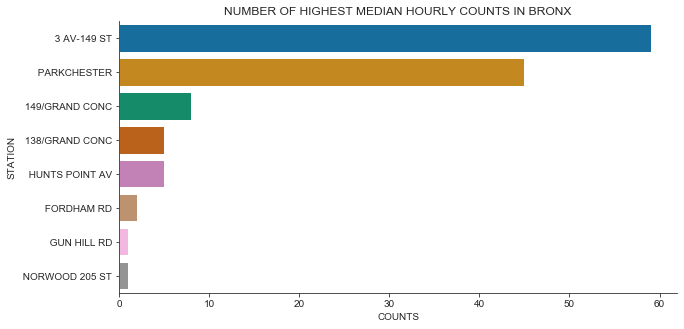

In [2335]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})
station_counts=station_counts.rename(columns={'index':'STATION',
                                   'Station':'COUNTS'})
sns.barplot(y='STATION', x='COUNTS', data=station_counts)
sns.set_palette("colorblind")
sns.despine()
plt.title('NUMBER OF HIGHEST MEDIAN HOURLY COUNTS IN BRONX')
plt.ylabel('STATION')
plt.xlabel('COUNTS')


#counting the number of times each station appears. This is reassuring our results with the weekly_plot_data 
station_counts=stations_df['Station'].value_counts().reset_index()
station_counts

- Now, we'll want to get a breakdown of how the highest median exits per hour per day. Creating dataframes with each day and the business hours we can expect for each day of the week.

In [2389]:
monday_df=stations_df[(stations_df['Day']=='0') & (pd.to_numeric(stations_df['Hour'])>7) & (pd.to_numeric(stations_df['Hour'])<22)]
tuesday_df=stations_df[(stations_df['Day']=='1') & (pd.to_numeric(stations_df['Hour'])>7) & (pd.to_numeric(stations_df['Hour'])<22)]
wednesday_df=stations_df[(stations_df['Day']=='2') & (pd.to_numeric(stations_df['Hour'])>7) & (pd.to_numeric(stations_df['Hour'])<22)]
thursday_df=stations_df[(stations_df['Day']=='3') & (pd.to_numeric(stations_df['Hour'])>7) & (pd.to_numeric(stations_df['Hour'])<22)]
friday_df=stations_df[(stations_df['Day']=='4') & (pd.to_numeric(stations_df['Hour'])>7) & (pd.to_numeric(stations_df['Hour'])<22)]
saturday_df=stations_df[(stations_df['Day']=='5') & ((pd.to_numeric(stations_df['Hour'])<2) | (pd.to_numeric(stations_df['Hour'])>8))]
sunday_df=stations_df[(stations_df['Day']=='6') & ((pd.to_numeric(stations_df['Hour'])<2) | (pd.to_numeric(stations_df['Hour'])>8))]


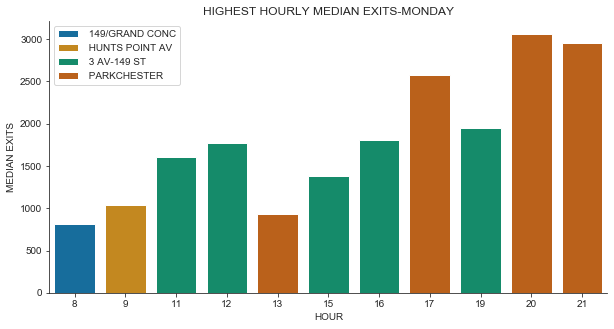

In [2373]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=monday_df,x=pd.to_numeric(monday_df['Hour']), y = pd.to_numeric(monday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-MONDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')


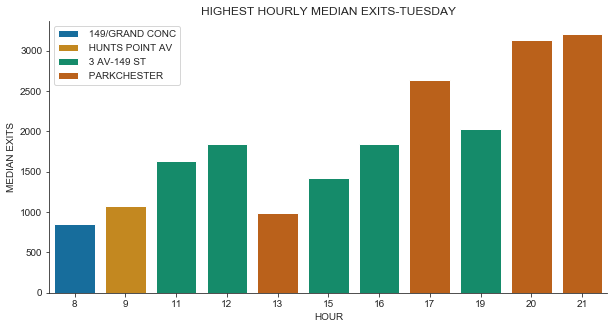

In [2386]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=tuesday_df,x=pd.to_numeric(tuesday_df['Hour']), y = pd.to_numeric(tuesday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-TUESDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

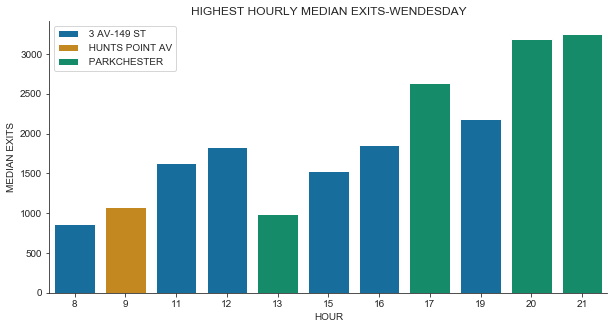

In [2375]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=wednesday_df,x=pd.to_numeric(wednesday_df['Hour']), y = pd.to_numeric(wednesday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-WENDESDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

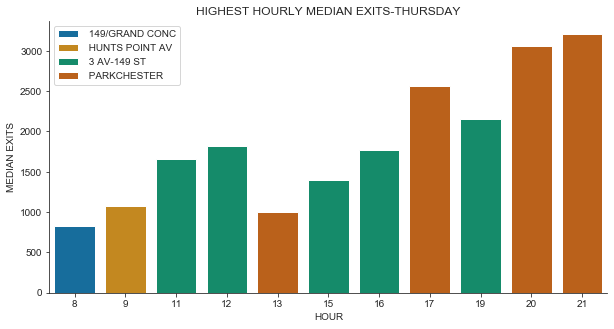

In [2376]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=thursday_df,x=pd.to_numeric(thursday_df['Hour']), y = pd.to_numeric(thursday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-THURSDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

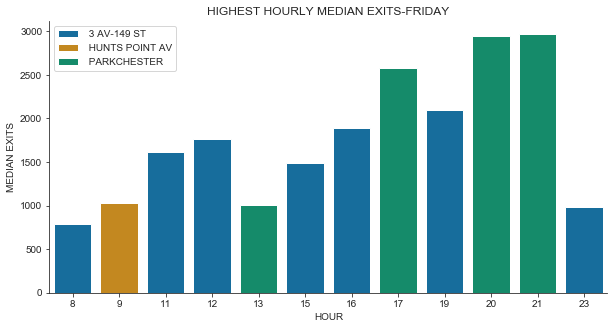

In [2388]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=friday_df,x=pd.to_numeric(friday_df['Hour']), y = pd.to_numeric(friday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-FRIDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

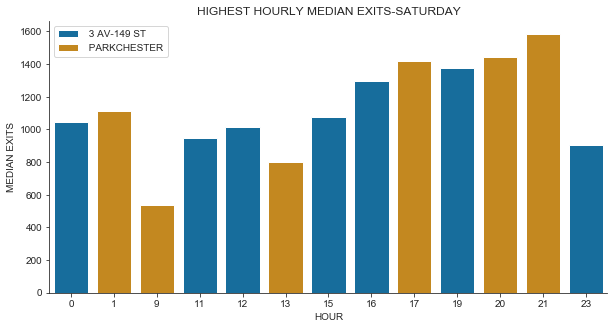

In [2378]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=saturday_df,x=pd.to_numeric(saturday_df['Hour']), y = pd.to_numeric(saturday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-SATURDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

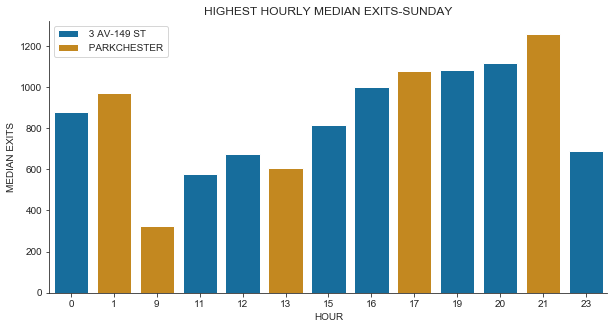

In [2379]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=sunday_df,x=pd.to_numeric(sunday_df['Hour']), y = pd.to_numeric(sunday_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST HOURLY MEDIAN EXITS-SUNDAY')
plt.ylabel('MEDIAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')

- #### Looking at the weekday data, we see that there is a common pattern with Parkchester and 3AV-149 St. We can find the averages for weekdays and group them together to make a plot that summarizes this pattern, which will inform our scheduling.

In [2380]:
#create dataframe with the week day mean values for the stations with the median max to create a weekday template
#Here we're selecting only weekdays, filtering the slow early/late hours, and finding the average for each hour, station, and line. This allows us to find the busiest stations for each hour during weekdays.
#We save a new dataframe with index info for the busiest stations on average at each our for weekdays. 

stations_df['HOURLY_EXITS']=pd.to_numeric(stations_df['HOURLY_EXITS'])                       
station_hourly_max_df=stations_df[(pd.to_numeric(stations_df['Day'])<5) &
                                  (pd.to_numeric(stations_df['Hour'])>7) &
                                  (pd.to_numeric(stations_df['Hour'])<22)]\
                                  .groupby(['Hour', 'Station','Line'])\
                                  .mean().groupby(['Hour']).idxmax().astype('str').reset_index()

station_hourly_max_df=pd.DataFrame(station_hourly_max_df['HOURLY_EXITS'].str.split(',', n = 3, expand = True))
station_hourly_max_df=station_hourly_max_df.applymap(lambda x: x.replace("'", ''))
station_hourly_max_df=station_hourly_max_df.applymap(lambda x: x.replace("(", ''))
station_hourly_max_df=station_hourly_max_df.applymap(lambda x: x.replace(")", ''))


In [2381]:
#create df that takes the max values to map those values on to the indexed df created above
#similarly, we want to find the values of those indexes that the above dataframe was created by. We then merge them.
shm_counts_df=stations_df[(pd.to_numeric(stations_df['Day'])<5) &
                          (pd.to_numeric(stations_df['Hour'])>7) &
                          (pd.to_numeric(stations_df['Hour'])<22)]\
                            .groupby(['Hour', 'Station','Line'])\
                            .mean().groupby(['Hour']).max().astype('str').reset_index()


#merge the actual max mean hourly counts with the stations_df
station_hourly_max_df['HOURLY_EXITS']=shm_counts_df['HOURLY_EXITS']

In [2382]:
#rename columns 
station_hourly_max_df.rename(columns={0: "Hour", 1: "Station",2:'Line'}, inplace=True)

station_hourly_max_df

,Hour,Station,Line,HOURLY_EXITS
0,11,3 AV-149 ST,25,1628.2
1,12,3 AV-149 ST,25,1808.2
2,13,PARKCHESTER,6,985.3
3,15,3 AV-149 ST,25,1443.2
4,16,3 AV-149 ST,25,1833.8
5,17,PARKCHESTER,6,2596.2
6,19,3 AV-149 ST,25,2081.4
7,20,PARKCHESTER,6,3076.8
8,21,PARKCHESTER,6,3116.8
9,8,149/GRAND CONC,245,832.3333333333334


- this plot is the result of consolidating the weekday information to find the busiest station per hour on average.  

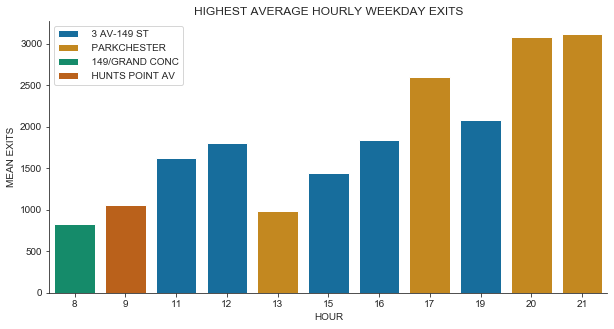

In [2390]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 10})

sns.barplot(data=station_hourly_max_df,x=pd.to_numeric(station_hourly_max_df['Hour']),
            y = pd.to_numeric(station_hourly_max_df['HOURLY_EXITS']), hue='Station',dodge=False)
sns.set_palette("colorblind")
sns.despine()
plt.title('HIGHEST AVERAGE HOURLY WEEKDAY EXITS')
plt.ylabel('MEAN EXITS')
plt.xlabel('HOUR')
plt.legend(loc='upper left')
